In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from feature_util import *
from utils import *

In [2]:
#import images, remove jokers and reset the index
data_path = 'Dataset/'
image_csv = pd.read_csv('Dataset/cards.csv')
image_csv = image_csv[image_csv['labels'] != 'joker']
image_csv = image_csv.reset_index(drop=True)
image_csv[:-10]

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
...,...,...,...,...,...
8014,50,valid/two of diamonds/1.jpg,two of diamonds,two,valid
8015,50,valid/two of diamonds/2.jpg,two of diamonds,two,valid
8016,50,valid/two of diamonds/3.jpg,two of diamonds,two,valid
8017,50,valid/two of diamonds/4.jpg,two of diamonds,two,valid


In [3]:
#creating a new label schema based on the suit
#clubs = 0, diamonds = 1, hearts = 2, spades = 3, joker = 10
      
suit_label = []
for label in image_csv['labels']:
    if 'clubs' in label:
        suit_label.append(0)
    elif 'diamonds' in label:
        suit_label.append(1)
    elif 'hearts' in label:
        suit_label.append(2)
    elif 'spades' in label:
        suit_label.append(3)

image_csv['Suit_Label'] = suit_label
image_csv[:-10]

,class index,filepaths,labels,card type,data set,Suit_Label
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,0
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,0
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,0
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,0
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,0
...,...,...,...,...,...,...
8014,50,valid/two of diamonds/1.jpg,two of diamonds,two,valid,1
8015,50,valid/two of diamonds/2.jpg,two of diamonds,two,valid,1
8016,50,valid/two of diamonds/3.jpg,two of diamonds,two,valid,1
8017,50,valid/two of diamonds/4.jpg,two of diamonds,two,valid,1


# Feature Point Matching 
Using SIFT (Scale-Invariant Feature Transformation) and FLANN (Fast Library for Approximate Nearest Neighbors) for feature point detection and Matching. 


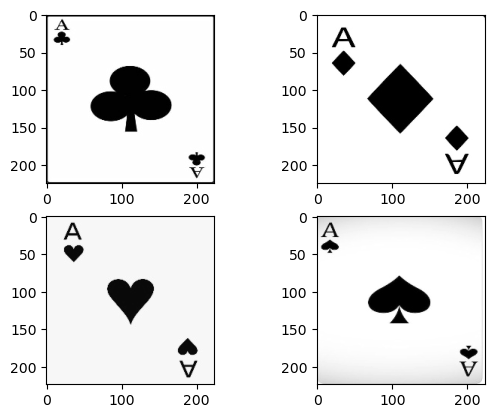

In [4]:
#display images
#define the image path
image_path = image_csv['filepaths']

#display the reference images
# reference_club_image = cv.cvtColor(plt.imread('Dataset/train/ace of clubs/083.jpg'), cv.COLOR_BGR2GRAY)
reference_club_image = convert_to_grayscale('train/ace of clubs/083.jpg')
reference_diamond_image = convert_to_grayscale('train/ace of diamonds/035.jpg')
reference_heart_image = convert_to_grayscale('train/ace of hearts/026.jpg')
reference_spade_image = convert_to_grayscale('train/ace of spades/064.jpg')

test_image = convert_to_grayscale(image_path[70])

figs, axes = plt.subplots(2,2)

axes[0,0].imshow(reference_club_image, cmap = 'gray')
axes[0,1].imshow(reference_diamond_image, cmap = 'gray')
axes[1,0].imshow(reference_heart_image, cmap = 'gray')
axes[1,1].imshow(reference_spade_image, cmap = 'gray')

plt.show()

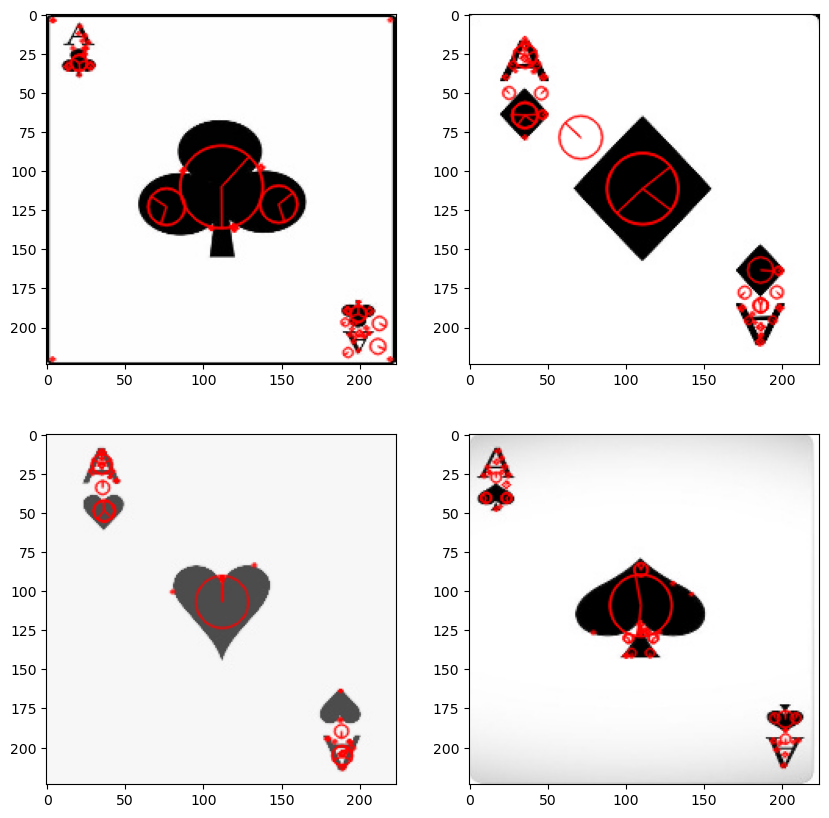

In [5]:
#display the feature points
clubs_features = sift_featue_detector(reference_club_image, 500)
diamonds_features = sift_featue_detector(reference_diamond_image, 500)
hearts_features = sift_featue_detector(reference_heart_image, 500)
spades_features = sift_featue_detector(reference_spade_image, 500)

figs, axes = plt.subplots(2,2, figsize = (10,10))

axes[0,0].imshow(clubs_features[0])
axes[0,1].imshow(diamonds_features[0])
axes[1,0].imshow(hearts_features[0])
axes[1,1].imshow(spades_features[0])

plt.show()

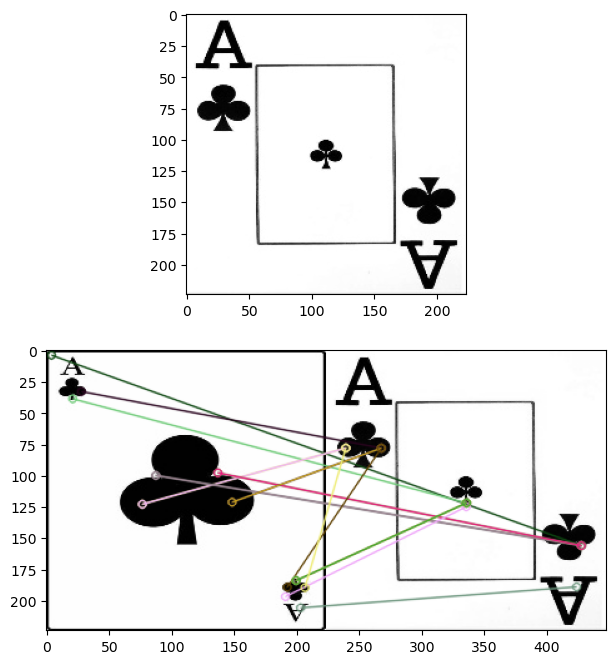

In [6]:
#Feature Point Matching using FLANN

#finding the key feature points and descriptors for the reference image and the images that we want to classify
key_f, key_d= sift_feature_descriptor(reference_club_image, 500)
key_f_img, key_d_img = sift_feature_descriptor(test_image, 500)

#Creating FLANN Based Matcher Parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks=100)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(key_d,key_d_img,k = 2)


##filter matches using Lowe's Ratio test
#setting ratio threshold for good matches
ratio_threshold = 0.85

#initalise an empty list to store the good matches
good_matches = []

for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

#overlay matches on to image
img_matches = np.empty((max(reference_club_image.shape[0], test_image.shape[0]), reference_club_image.shape[1]+test_image.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(reference_club_image, key_f, test_image, key_f_img, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

figs, axes = plt.subplots(2,1, figsize = [8, 8])

#dispplay the test image
axes[0].imshow(test_image, cmap = 'gray')

#display the images with the feature point matching
axes[1].imshow(img_matches, cmap = 'gray')

plt.show()

# Template Matching

**NOTE**: This template matching is scale, rotation and perspective invariant. It only works well with when the suit are the same size. 
Using Multi-scale templates, we were able to achieve better matching results but it still isn't a perfect process. It doesn't address significant differences between the style of the template and the suit

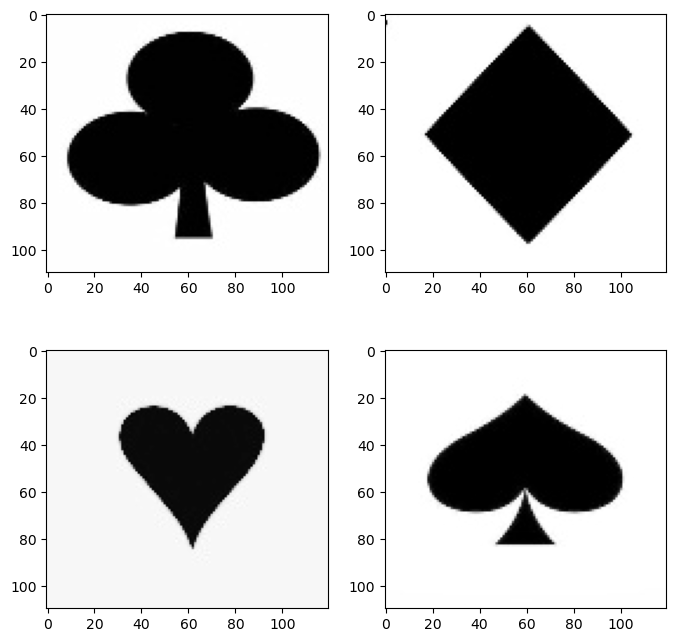

In [7]:
#Cropping the suit of the card to get the template

club_template = reference_club_image[60:170, 50:170]
diamond_template = reference_diamond_image[60:170, 50:170]
heart_template = reference_heart_image[60:170, 50:170]
spade_template = reference_spade_image[60:170, 50:170]

figs, axes = plt.subplots(2,2, figsize = (8, 8))
axes[0,0].imshow(club_template, cmap = 'gray')
axes[0,1].imshow(diamond_template, cmap = 'gray')
axes[1,0].imshow(heart_template, cmap = 'gray')
axes[1,1].imshow(spade_template, cmap = 'gray')
plt.show()

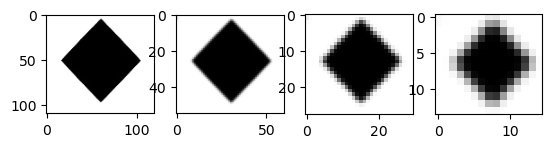

In [8]:
#pyramid Images for templates
template_image = pyramid_image(diamond_template)

figs, axes = plt.subplots(1, 4)
axes[0].imshow(template_image[0], cmap = 'gray')
axes[1].imshow(template_image[1], cmap = 'gray')
axes[2].imshow(template_image[2], cmap = 'gray')
axes[3].imshow(template_image[3], cmap = 'gray')

plt.show()

1


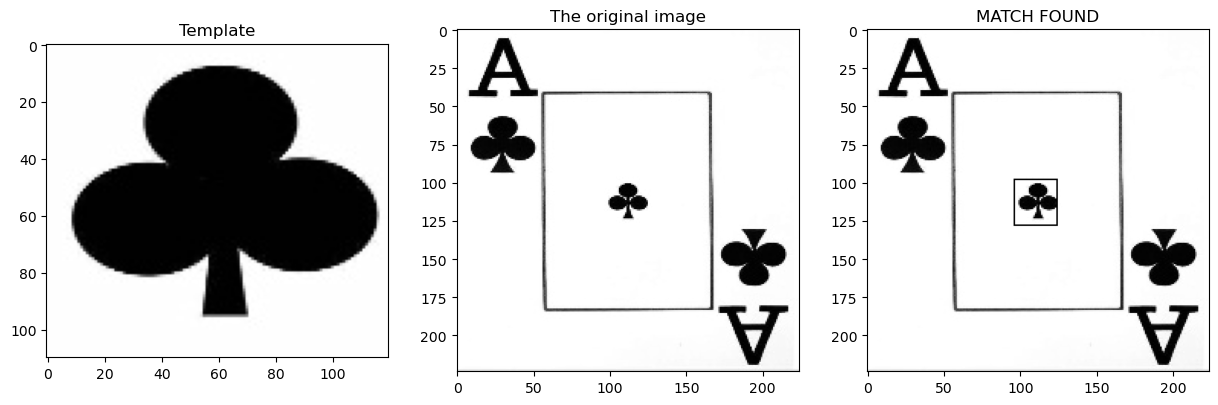

In [9]:
sqdiff = 0 #'cv.TM_SQDIFF'
norm_sqdiff = 1 #'cv.TM_SQDIFF_NORMED'
ccorr = 2 #'cv.TM_CCORR'
norm_ccorr = 3 #'cv.TM_CCORR_NORMED'
ccoeff = 4 #'cv.TM_CCOEFF'
norm_ccoeff = 5 #'cv.TM_CCOEFF_NORMED'

test_image_2 = convert_to_grayscale(image_path[70])
template_images = pyramid_image(club_template)
result = match_template(template_images, test_image_2, norm_ccoeff)

figs, axes = plt.subplots(1,3, figsize = (15,8))
axes[0].imshow(result[2], cmap = 'gray')
axes[0].set_title('Template')
axes[1].imshow(result[1], cmap = 'gray')
axes[1].set_title('The original image')
axes[2].imshow(result[0], cmap = 'gray')
axes[2].set_title(result[3])

plt.show()